#### time = 20、二维

In [1]:
# 
# 数据读入和预处理,读取数据较慢
# import pandas as pd
# import numpy as np

# # 10000条数据的情况 理论预测——6.8061，蒙特卡洛--6.8587，最终运行结果——
# # st_train = pd.read_excel(r'time20/st_train20.xlsx',header=None)
# # vt_train =  pd.read_excel(r'time20/vt_train20.xlsx',header=None)
# st_val =  pd.read_excel(r'time20/st_val20.xlsx',header=None)
# vt_val =  pd.read_excel(r'time20/vt_val20.xlsx',header=None)

# # 验证数据 256 条数据
# X_val = np.zeros([st_val.shape[0],2,st_val.shape[1]])
# for i in range(256):
#     X_val[i,0] = st_val.iloc[i,:]
#     X_val[i,1] = vt_val.iloc[i,:]

# # 训练数据 10000 条数据
# # X_train = np.zeros([st_train.shape[0],2,st_train.shape[1]])     
# # for i in range(10000):
# #     X_train[i,0] = st_train.iloc[i,:]
# #     X_train[i,1] = vt_train.iloc[i,:]    
# X_val.shape# 数据读入和预处理,读取数据较慢

(256, 2, 20)

In [7]:
import numpy as np
# 随机数种子
np.random.seed(70)
Rate = 0.03;Strike = 100;V0 = 0.1;ThetaV = 0.15;Kappa = 1;SigmaV = 0.2;RhoSV = -1;S0 = 100;K = Strike;X = np.log(S0/K)
V0 = V0;kappa = Kappa;theta = ThetaV;sigma = SigmaV;rho = RhoSV;gamma = 2;r = Rate;dt = 1/250;D = 20;tau = dt*D;c1 = 3.6315
def henston_paths(num3):
    S = np.zeros((num3,D))
    V = np.zeros((num3,D))
    S[:,0] = S0
    V[:,0] = V0
    for i in range(1,D):
        W1 = np.random.randn(num3)
        W1_5 = np.random.randn(num3)
        W2 = W1*rho + W1_5*np.sqrt(1-rho**2)
        V[:,i] = V[:,i-1]+kappa*(theta-V[:,i-1])*dt + sigma*(V[:,i-1]**gamma) * np.sqrt(dt)*W1
        S[:,i] = np.exp(np.log(S[:,i-1])+(r-0.5*V[:,i-1])*dt+np.sqrt(V[:,i-1]*dt)*W2)
    # 蒙特卡洛值
    c2 = np.mean([max(i-K,0) for i in S[:,-1]])*np.exp(-r*tau)
    return S,V,c2
# 验证数据 256 条数据
# X_val = np.zeros([st_val.shape[0],2,st_val.shape[1]])
# for i in range(256):
#     X_val[i,0] = st_val.iloc[i,:]
#     X_val[i,1] = vt_val.iloc[i,:]

# 训练数据 10000 条数据
S,V,c2 = henston_paths(10000)
X_train = np.zeros([S.shape[0],2,S.shape[1]])     
for i in range(10000):
    X_train[i,0] = S[i,:]
    X_train[i,1] = V[i,:]    
X_train.shape# 数据读入和预处理,读取数据较慢


# 验证数据 256 条数据
st_val,vt_val,c3 = henston_paths(256)
X_val = np.zeros([st_val.shape[0],2,st_val.shape[1]])
for i in range(256):
    X_val[i,0] = st_val[i,:]
    X_val[i,1] = vt_val[i,:]
### 10000条蒙特卡洛的值
c2,c3

(3.660023053018153, 3.448405633054467)

In [8]:
'''
损失函数是loss=E（|ST-K-u（T)|2），240个网络
'''
import time  
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow.python.training.moving_averages import assign_moving_average   # 移动平均
from scipy.stats import multivariate_normal as normal            # 产生正态分布随机数
from tensorflow.python.ops import control_flow_ops               #用于控制流  
from tensorflow import random_normal_initializer as norm_init    #生成具有正态分布的张量的初始化器
from tensorflow import random_uniform_initializer as unif_init   #生成具有均匀分布的张量的初始化器
from tensorflow import constant_initializer as const_init        #生成具有常量值的张量的初始化器


class SolveAllenCahn (object):
    """ The fully-connected neural network model """  
    def __init__ (self,sess):
        self.sess = sess   # 会话       
        # 在满足条件的情况下估计c0的值
        self.d = 2      # 数据的维度
        self.T = 20.0/250      # 每一条路径的时间长度
        # parameters for the algorithm
        self.dt = 1/250    # 每一个路径中数据时间间隔，delta t = 1/32
        self.n_time = int(self.T/self.dt)     # 有20个t
        self.n_layer = 4     # 神经网络的层数
        self.n_neuron = [self.d ,self.d +12 ,self.d +12, self.d]    # 各层神经元的个数，对应输入、隐藏层1、隐藏层2、输出
        self.batch_size = 128      # 一次用到个路径计算，64*4=256
        self.valid_size =256     # 256个蒙特卡洛样本（路径）
        self.n_maxstep = 8000     # 迭代步数
        self.n_displaystep = 100     # 每100步print一次
        self.learning_rate = 8e-4    # 学习率
        self.Yini = [1.8,5.4]      # 初始值Y0的最大最小值
        # some basic constants and variables

        self.sqrth = math.sqrt(self.dt)    # 根号delta t，后面用于计算
        self.t_stamp = np.arange(0,self.n_time)*self.dt  # 时间戳，累计的时间
        self._extra_train_ops = []  # batch移动平均值操作，其中需要额外训练的beta和gamma
        
        # 参数第1组(case1)
        self.sigma = 0.2
        self.kappa = 1
        self.theta = 0.15
        self.gamma = 2
        self.r = 0.03
        self.rho = -1.00
        self.S0 = 100
        self.V0 = 0.1
        self.K = 100
        self.paths = 10000    ## 所用总路径数
        self.epoch_splits = int(self.paths/self.batch_size) - 1 
        
    def train(self):
        # 主要函数，用于神经网络的训练
        start_time = time.time()   # 起始时间
        self.global_step = \
            tf.get_variable('global_step', [] ,
                              initializer = tf.constant_initializer(1),
                              trainable = False,dtype = tf.int32 )   # 没有添加到要训练的变量列表，计步器
        trainable_vars = tf.trainable_variables()  # 查看可训练的变量
        grads = tf.gradients(self.loss,trainable_vars)  # loss可训练变量的梯度
        optimizer = tf.train.AdamOptimizer(self.learning_rate)    # 梯度优化器
        apply_op = \
            optimizer.apply_gradients(zip(grads,trainable_vars) ,    # 将梯度用来更新trainable_vars列表中的东西
                                          global_step = self.global_step)   # 更新梯度和迭代次数
        
        train_ops = [apply_op] + self._extra_train_ops   # 添加操作，相当于list1.extand(list2)
        self.train_op = tf.group(* train_ops)   # tf.group(*train_ops)组合*train_ops的操作
        
        self.loss_history = []   # 用于记录loss值
        self.init_history = []   # 用于记录Y0的值
        
        # for validation,256条蒙特卡洛做验证集
        dW_valid , X_valid = self.sample_path(self.valid_size,0,tra=False)   # 生成数据
        feed_dict_valid = { self.dW : dW_valid,   # 喂数据给buildmodel中的占位符
                            self.X : X_valid,
                            self.is_training: False}   # 不列入迭代范围
        # initialization
        step = 1
        self.sess.run (tf.global_variables_initializer())  # 初始化全局变量
        
        # 运行框架
        temp_loss = self.sess.run(self.loss ,
                                  feed_dict = feed_dict_valid )  # 计算损失
                
        temp_init = self.Y0.eval()[0] # # 取出值，Y0是二维张量
        self.loss_history.append(temp_loss)  # 记录loss
        self.init_history.append(temp_init)  # 记录Y0
        print("step : %5u , loss : %.4e , " % \
                (0 ,temp_loss ) + \
                "Y0 : % .4e , runtime : %4u " % \
                (temp_init, time.time()-start_time + self.t_bd))   # 打印step=0的状态
        
        # begin sgd iteration，0-4000步
        for i in range (self.n_maxstep +1):   
            step = self.sess.run (self.global_step)
            dW_train,X_train = self.sample_path(self.batch_size,i,tra=True)  # 生成数据
            self.sess.run(self.train_op,
                          feed_dict ={self.dW : dW_train ,   # 喂数据给buildmodel中的占位符
                                      self.X : X_train ,
                                      self.is_training : True })
            if step % self.n_displaystep == 0:   # 每100步用验证集测试一下损失和Y0的值
                temp_loss = self.sess.run(self.loss ,
                                          feed_dict = feed_dict_valid)
                temp_init = self.Y0.eval()   # 取出值
                self.loss_history.append(temp_loss)    # 损失值
                self.init_history.append(temp_init )   # Y0值，Y0是二维张量
                print("step : % 5u , loss : %.8e , " % \
                        ( step , temp_loss ) + \
                        " Y0 : % .4e , runtime : %4u " % \
                        (temp_init , time.time() - start_time + self.t_bd ))
            step += 1
        end_time = time.time()  # 训练结束的总时间
        print(" running time : % .3f s " % \
                ( end_time - start_time + self.t_bd ))

    def build(self):
        # build the whole network by stacking subnetworks，构架大网络
        start_time = time.time () 
        # dW、X、is_training的占位符，为什么是None,因为一次计算一个batch
        self.dW = tf.placeholder(tf.float64 ,[ None , self.d , self.n_time] ,name = 'dW')   # None*100*20
        self.X = tf.placeholder(tf.float64 ,[ None , self.d , self.n_time] ,name = 'X')   # None*100*20
        self.is_training = tf.placeholder (tf.bool)
        
        # 初始化Y0\Z0
        self.Y0 = tf.Variable(tf.random_uniform([1],                      # u0初始化,一个维度一个值  
                                                minval = self.Yini [0] ,   # 最小值 
                                                maxval = self.Yini [1] ,   # 最大值
                                                dtype = tf.float64 ));
        self.Z0 = tf.Variable (tf.random_uniform ([1,self.d] ,    # u梯度的初始值，一个1*d 向量
                                                minval = -.1 ,   # 最小值
                                                maxval =.1 ,    # 最大值
                                                dtype = tf.float64 ))
        self.allones = \
             tf.ones(shape = tf.stack([ tf.shape(self.dW)[0],1]) ,   # tf.shape(self.dW)[0]=len(batch),shape=(batch,1)
                         dtype = tf.float64 )                        # 作用，批量（batch）产生初始值

        Y = self.allones * self.Y0  # 初始的Y作为输入,每一个batch都赋予相同的初始Y值，Y是一个(batch,1)二维矩阵[[],[],..,]
        Z = tf.matmul(self.allones, self.Z0 )  # 初始的Z做为输入，作用和Y相同，但是由于Z是一个向量所以要乘积（batch,d）矩阵
        
        
        with tf.variable_scope('forward'):   # 前向
            for t in range(self.n_time -1):  # 前N-1个xt的网络
                    Y = self.f_tf(self.t_stamp[t],Y,Z,self.X[:,:,t],self.dW[:,:,t])  # 递推公式      # @@@@@@@@@@
                    Z = self._one_time_net(self.X[:,:,t+1] ,  # 得到“u梯度”-- 由神经网络训练而来的。
                                       str(t +1))   # /self.d  
            # terminal time，因为最后一刻的Y不用神经网络了
            Y = self.f_tf(self.t_stamp[self.n_time -1] ,        # @@@@@@@@@@
                                  Y,Z,self.X[:,:, -1] , 
                                  self.dW[:,:, -1])   
            term_delta = Y - self.g_tf(self.T,self.X[:,:,-1]) # 损失函数公式   # @@@@@@@@@@
            self.clipped_delta = \
                  tf.clip_by_value(term_delta ,-50.0 , 50.0)  #将一个张量中的数值限制在一个范围之内，大于为上界，小于为下界
            self.loss = tf.reduce_mean(self.clipped_delta**2)+(self.Y0-3.6315)**2 #计算损失，来源于损失函数
        self.t_bd = time.time() - start_time  # 生成网络的时间


    def sample_path(self, n_sample,s,tra=True):
        # i~(0,1999)
        dW = np.zeros([n_sample,self.d,self.n_time])
        # 多条路径
        for i in range(n_sample):
            z11 = np.random.randn(self.n_time)*self.sqrth
            z12 = np.random.randn(self.n_time)*self.sqrth
            w1 = z11
            w2 = self.rho*z11+np.sqrt(1-self.rho**2)*z12
            dW[i,0]=w1
            dW[i,1]=w2
        if tra == True:
            s = s % self.epoch_splits
            X = X_train[s*n_sample:(s+1)*n_sample]
        else:
            X = X_val
        return dW,X
            
    def g_tf(self,t,X):                                               # @@@@@@@@@@
        # terminal conditions
        return  tf.nn.relu(X[:,0]-self.K)  # X[:,0]是T时刻的ST值，重写了g(x)     # @@@@@@@@@@

    def f_tf(self,t,Y,Z,X,dW):   # @@@@@@@@@@重写了递推公式                   
        f = tf.reshape((Z[:,0]*tf.sqrt(X[:,1])*X[:,0]*dW[:,0]+Z[:,1]*self.sigma*pow(X[:,1],self.gamma/2)*dW[:,1]),shape=(-1,1))# @@@@@@@
        return Y + self.r*Y*self.dt + f

    def _one_time_net(self , x ,name ):
        # x.shape = (batch,2)，得到z.shape=(batch,2)。输入的数据含有t,当t确定x就是二维的
        # 一个batch在t时刻的网络构架，输出梯度,不用
        with tf.variable_scope(name):
            x_norm = self._batch_norm(x, name = 'layer0_normal')  # 对batch标准化，作为输入
            layer1 = self._one_layer(x_norm , self.n_neuron [1] ,   # 隐藏层1输入输出input(batch,d),output(batch，d+10)
                                      name = 'layer1')
            layer2 = self._one_layer(layer1,self.n_neuron[2] ,  # 隐藏层2 input(batch,d+10),output(batch,d+10)
                                      name = 'layer2')
            z = self._one_layer(layer2 , self.n_neuron [3] , #  输出层，不加relu函数做激活input(batch,d+10),output(baatch,d)
                                     activation_fn = None , name = 'final')
        return z

    def _one_layer(self , input_ , out_sz ,activation_fn = tf.nn.elu ,std =5.0 , name = 'linear'):
        # 输入input_=（batch,d）,输出(batch,out_sz)
        # 一个层里面的计算操作,一个层的输入，返回一个层的输出0，被_one_time_net调用用于构造一个时刻的神经网络
        with tf.variable_scope(name):
            shape = input_.get_shape().as_list()  # list(输入的维度)
            w = tf.get_variable('Matrix',     # get_variable它一定是和tf.variable_scope()共同使用的
                                [shape[1], out_sz] ,tf.float64,    # 输入维度和输出维度
                                norm_init(stddev = \
                                          std / np.sqrt(shape[1]+ out_sz )))  # 生成权重矩阵
            hidden = tf.matmul(input_ ,w)  # 矩阵乘积，隐藏计算中间结果
            hidden_bn = self._batch_norm(hidden, name = 'normal')  # batch标准化
            
        if activation_fn != None :
            return activation_fn(hidden_bn)  # 激活函数
        else :
            return hidden_bn  #不加激活函数,线性,最后一层网络

    def _batch_norm(self , x , name ):
        # 输入的和输出的shape相同
        """ Batch normalization """ # beta、gamma需要训练，第三类参数来源,一次标准化需要2列参数
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[ -1]]   # [d,d+10,d+10,d]，第一个维度是batch
            beta = tf.get_variable('beta', params_shape ,
                                         tf.float64 ,
                                         norm_init(0.0 , stddev =0.1 ,  # 正态分布随机数
                                         dtype = tf.float64 ))
            gamma = tf.get_variable( 'gamma', params_shape ,
                                         tf.float64 ,
                                         unif_init (0.1,0.5 ,   # 均匀分布随机数
                                         dtype = tf.float64 ))
            mv_mean = tf.get_variable('moving_mean' ,   # 由于每次的batch不同，所以用moving_mean来改进mean
                                         params_shape ,
                                         tf.float64 ,
                                         const_init (0.0 ,tf.float64 ) ,  # 初始化为0
                                         trainable = False )
            mv_var = tf.get_variable('moving_variance' ,
                                        params_shape ,
                                        tf.float64 ,
                                        const_init(1.0 , tf.float64 ) ,  # 初始化为1
                                        trainable = False )
            
            # These ops will only be preformed when training
            mean ,variance = tf.nn.moments(x ,[0] , name = 'moments')#需要标准化的中心维度,[0]表示batch,求64个数据的均值方差
            self._extra_train_ops.append (\
                 assign_moving_average(mv_mean , mean , 0.99))  # 下面详解
            self._extra_train_ops.append (\
                 assign_moving_average(mv_var , variance , 0.99))
            
            mean,variance = \
                control_flow_ops.cond(self.is_training ,            # control_flow_ops.cond控制执行流，第一个为条件
                                     lambda :( mean , variance ) , # 条件True时执行，train时，需要进行重新求均值方差
                                     lambda :( mv_mean , mv_var )) # 条件False时执行,test时，直接调用最后一次的平滑值
            
            y = tf.nn.batch_normalization (x , mean , variance ,
                                           beta , gamma , 1e-6)   
            # 上面一步的操作相当于:  
            # y = (y - mean)/tf.sqrt(variance+1e-6)  # 1e-6 epslion
            # y = y * gamma + beta
            # 确保标准化后的形状不变
            y.set_shape( x.get_shape())
            return y

def main ():
    # 运行框架
    rs = []
    tf.reset_default_graph ()
    with tf.Session() as sess :
        tf.set_random_seed (1)  # tf中的随机种子
        print(" Begin to solve Heston model 下期权定价 ")
        model = SolveAllenCahn (sess)  # 创建对象
        print('开始构建网络')
        model.build()   # 调用对象方法，构建了一个模型，即定义了各个解，但没有传入数据
        print('网络构建完成')
        model.train ()  # 生成并传数据到build
#         output = np.zeros ((len(model.init_history), 3))   # 初始化结果为0,后面填充
#         output[:,0] = np.arange(len( model.init_history ))* model.n_displaystep         # 输出step
#         output[:,1] = model.loss_history  # 输出loss列表
#         output[:,2] = model.init_history # 输出 Y0列表
#         np.savetxt("./ Henston_d100.csv " ,  # 保存输出结果
#                      output ,
#                      fmt =[ '%d', '%.5e', '%.5e'] ,
#                      delimiter =",",
#                      header ="step ,loss function , " + \
#                      " target value , runtime " ,
#                      comments = '')

if __name__ == '__main__':
        np.random.seed(1) # 定义一个随机数种子
#         for i in range(5):
#             print(str(i)+' run:')
#             random.shuffle(X_train)
        main()  # 运行主程序
    
## 运行结果保存在

 Begin to solve Heston model 下期权定价 
开始构建网络
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
网络构建完成
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
step :     0 , loss : 2.0860e+03 , Y0 :  2.4081e+00 , runtime :   24 
step :   100 , loss : 3.89572260e+01 ,  Y0 :  2.4847e+00 , runtime :   35 
step :   200 , loss : 3.54750588e+01 ,  Y0 :  2.5597e+00 , runtime :   37 
step :   300 , loss : 3.25607432e+01 ,  Y0 :  2.6311e+00 , runtime :   39 
step :   400 , loss : 3.15963395e+01 ,  Y0 :  2.6990e+00 , runtime :   41 
step :   500 , loss : 3.06436739e+01 ,  Y0 :  2.7658e+00 , runtime :   43 
step :   600 , loss : 3.00535981e+01 ,  Y0 :  2.8311e+00 

#### 收敛均值，最后20个

In [9]:
a = [3.6404e+00 , 
3.6368e+00 , 
3.6391e+00 , 
3.6418e+00 , 
3.6372e+00 , 
3.6388e+00 , 
3.6404e+00 , 
3.6391e+00 , 
3.6380e+00 , 
3.6390e+00 , 
3.6408e+00 , 
3.6368e+00 , 
3.6392e+00 , 
3.6418e+00 , 
3.6374e+00 , 
3.6388e+00 , 
3.6403e+00 , 
3.6393e+00 , 
3.6379e+00 , 
3.6390e+00 , 
3.6409e+00 ]
b = np.mean(a)
b

3.639180952380952

#### 效果比较好的loss和c0

In [41]:
import pandas as pd
import numpy as np
showd = pd.read_csv(r'time20/best_data.csv')
steps = showd['steps'][1:]
loss = showd['loss'][1:]
c0 = showd['c0'][1:]

3.6225300000000002


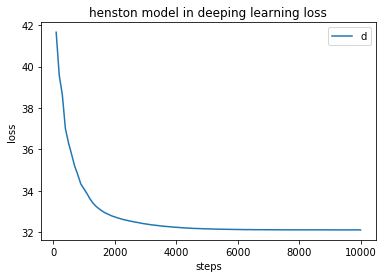

In [47]:
import matplotlib.pyplot as plt
plt.plot(steps,loss)
print(np.mean(c0[-20:]))
plt.title('henston model in deeping learning loss')
plt.ylabel('loss')
plt.xlabel('steps')

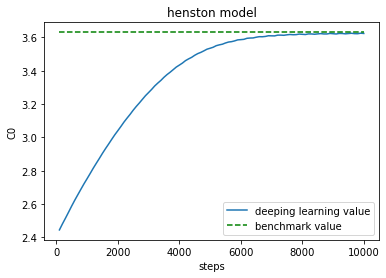

In [46]:
plt.plot(steps,c0)
plt.plot(steps,[3.6315]*100,'--',c='g')
plt.title('henston model')
plt.ylabel('C0')
plt.xlabel('steps')
plt.legend(['deeping learning value','benchmark value'])

##### 多次结果   MCMC和DEEP 比较

Text(0.5, 0, 'test')

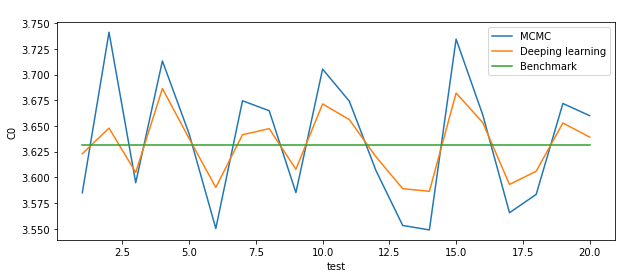

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_excel(r'C:\Users\Administrator\Desktop\task\yyh\MCMCVSDEEP\结果\20个记录.xlsx')

MCMC = data['MCMC']
d = data['DEEP']
b = data['benchmark']
x = range(1,21)
plt.figure(figsize=(10,4))
plt.plot(x,MCMC)
plt.plot(x,d)
plt.plot(x,b)
plt.legend(['MCMC','Deeping learning','Benchmark'])
plt.title(' ')
plt.ylabel('C0')
plt.xlabel('test')

### 50维 20time

In [9]:
import numpy as np
dt = 1/250
D = 20
tau = dt*D
M = 50
num = 1000
K = 100
S = np.zeros([num,D*M])
V = np.zeros([num,D*M])
w = np.zeros([M,1])

for i in range(M):
    S[:,i*D] = 100 + np.random.randn(1,1)
    V[:,i*D] = abs(np.random.randn(1,1)/20)
    w[i,0] = 1/M
    
r = 0.03
kappa = 1
theta = 0.15
sigma = 0.2
rho = -1.0
gamma = 2
for k in  range(M):
    for i in  range(1,D):    
        j = k*D + i
        W1 = np.random.randn(num)
        W1_5 = np.random.randn(num)
        W2 = W1*rho + W1_5*np.sqrt(1-rho**2)
        V[:,j] = V[:,j-1]+kappa*(theta-V[:,j-1])*dt+sigma*(V[:,j-1]**gamma)*np.sqrt(dt)*W1
        S[:,j] = np.exp(np.log(S[:,j-1])+(r-0.5*V[:,j-1])*dt+np.sqrt(V[:,j-1]*dt)*W2)

S_end =  np.zeros(num,M)
for i in range(M):
    S_end[:,i] = S[:,i*D]

c_end = np.zeros(num,1)
for i in range(num):
    c_end[i,1] = [max(h-K,0) for h in S_end[i,:]*w]

c0 = np.mean(c_end)*exp(-r*tau)

TypeError: data type not understood